In [52]:

import numpy as np
import pandas as pd
# Example matrix
matrix_size = 100
data = pd.read_parquet('/Users/dima/Documents/dpp4nlp/data/encoded_texts.parquet', engine='pyarrow')

In [53]:
embs = np.array(data['article_embedding'].to_list())
embs.shape

(3000, 1024)

In [38]:
# data = np.load("/Users/dima/Documents/dpp4nlp/data/embeddings_tensor_50.npy")

In [150]:
from diffprivlib.mechanisms import Exponential

def similarity(u, v):
    dot_product_uv = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    
    similarity_uv = dot_product_uv / (norm_u * norm_v)
    return similarity_uv

def kernel_matrix(data):
    n = len(data)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = similarity(data[i], data[j])
    return K

def select_eigenvectors(eigenvalues, eigenvectors, n, dp=True):
    selected_eigenvalues = []
    selected_eigenvectors = []
    if dp:
        eps = np.abs(np.log(n) - np.log(n - 1))
        # probs = np.log(eigenvalues)
        # probs = [x if not np.isnan(x) else -100 for x in probs]
        

    for eigenvalue, eigenvector in zip(eigenvalues, eigenvectors.T):
        
        if dp:
            p = np.log(eigenvalue) if not np.isnan(np.log(eigenvalue)) else -100
            bin_mech = Exponential(epsilon=2*eps, sensitivity=eps, utility=[0, p])
            prob = bin_mech.randomise()
            if prob > 0:
                selected_eigenvalues.append(eigenvalue)
                selected_eigenvectors.append(eigenvector)
        else:
            prob = eigenvalue / (eigenvalue + 1)
            if np.random.rand() < prob:
                selected_eigenvalues.append(eigenvalue)
                selected_eigenvectors.append(eigenvector)
    
    return np.array(selected_eigenvalues), np.array(selected_eigenvectors).T


def select_items(eigenvectors, items, idxs=True):
    subset_Y = []

    for eigenvector in eigenvectors.T:
        # Calculate squared magnitude of components
        squared_magnitude = np.square(np.abs(eigenvector))

        # Normalize squared magnitudes to probabilities
        # probabilities = squared_magnitude / np.sum(squared_magnitude)

        # Select an item based on probabilities
        selected_index = np.random.choice(len(eigenvector), p=squared_magnitude)
        if idxs:
            subset_Y.append(selected_index)
        else:
            selected_item = items[selected_index]
            subset_Y.append(selected_item)
    
    return subset_Y

def probability_of_selection(K, Y):
    # Extract submatrix Ky
    Ky = K[Y][:, Y]
    
    # Compute determinants
    det_Ky = np.linalg.det(Ky)
    det_K_plus_I = np.linalg.det(K + np.eye(K.shape[0]))  # Adding identity matrix
    
    # Compute probability of selection
    probability = det_Ky / det_K_plus_I
    
    return probability


In [142]:
K = kernel_matrix(embs)
eigenvalues, eigenvectors = np.linalg.eig(K)


In [151]:
selected_val, selected_vec = select_eigenvectors(eigenvalues, eigenvectors, dp=True, n=len(data))

/var/folders/br/gc6vlxzj7kb1h9qj5qzxxxlw0000gn/T/ipykernel_13208/1790916645.py:31: RuntimeWarning: invalid value encountered in log
  p = np.log(eigenvalue) if not np.isnan(np.log(eigenvalue)) else -100


In [144]:
final_vecs = select_items(selected_vec, data)

In [152]:
len(final_vecs)

1067

In [64]:
import pandas as pd

ds = pd.read_csv("/Users/dima/Documents/dpp4nlp/data/News_Category_Dataset_v3_50.csv")

for j in final_vecs:
    print(data.iloc[j]["category"])


TASTE
IMPACT
GOOD NEWS
FOOD & DRINK
POLITICS
POLITICS
BUSINESS
PARENTS
COMEDY
POLITICS
FOOD & DRINK
SPORTS
ARTS
WORLD NEWS
ENTERTAINMENT
POLITICS
ENTERTAINMENT
POLITICS
POLITICS
FOOD & DRINK
SPORTS
ENTERTAINMENT
TECH
POLITICS
STYLE & BEAUTY
IMPACT
THE WORLDPOST
PARENTING
POLITICS
FOOD & DRINK
POLITICS
POLITICS
ENTERTAINMENT
FIFTY
U.S. NEWS
FOOD & DRINK
POLITICS
POLITICS
POLITICS
BLACK VOICES
TRAVEL
STYLE & BEAUTY
DIVORCE
ENTERTAINMENT
WOMEN
MONEY
RELIGION
POLITICS
MONEY
FOOD & DRINK
TRAVEL
POLITICS
BUSINESS
WOMEN
POLITICS
FOOD & DRINK
PARENTS
POLITICS
CRIME
ENTERTAINMENT
COMEDY
POLITICS
POLITICS
BLACK VOICES
POLITICS
ENTERTAINMENT
WELLNESS
TRAVEL
HEALTHY LIVING
SCIENCE
BUSINESS
POLITICS
IMPACT
WEIRD NEWS
WELLNESS
QUEER VOICES
QUEER VOICES
POLITICS
POLITICS
COLLEGE
POLITICS
HOME & LIVING
PARENTS
STYLE & BEAUTY
HEALTHY LIVING
STYLE & BEAUTY
WORLDPOST
TRAVEL
ENTERTAINMENT
CRIME
HOME & LIVING
PARENTING
WELLNESS
WELLNESS
POLITICS
IMPACT
FOOD & DRINK
ENTERTAINMENT
PARENTING
WELLNESS
STYLE
SP

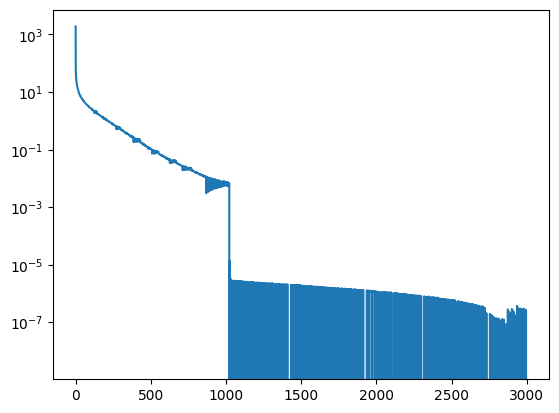

In [36]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(eigenvalues)